In [91]:
#IMPORT LIBRARIES
import sqlite3
import os
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from itertools import product
from math import ceil
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline
#from pandas_profiling import ProfileReport 
%config InlineBackend.figure_format = 'retina' 
from scipy.stats import iqr as IQR
from collections import Counter
import scipy.stats as stat
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

# Seeting seaborn style
sns.set()

Collect initial data

In [2]:
#import file csv
df = pd.read_csv('retail.csv')
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Describe, explore and assess data quality

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.replace("", np.nan, inplace=True)

In [7]:
# Summary statistics for all variables
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#FUNCTION TO SHOW MISSING VALUES AND THEIR PERCENTAGES
def missing_data(df):
    l = []
    for col in df.columns:
        missing = df[col].isnull().sum(axis=0)
        percentage = missing/df.shape[0]
        l.append([col,missing,percentage*100])
        df_missing = pd.DataFrame(l, columns = ['Feature','missing','percentage'])
        df_missing = df_missing.sort_values('missing',axis=0, ascending = False)    
    return df_missing

In [9]:
df_missing = missing_data(df)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,135080,24.926694
2,Description,1454,0.268311


In [10]:
# Check duplicated observations
df.loc[df.duplicated(keep=False), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [11]:
# Create dataframe copy
df1 = df.copy()

## Data Preparation:

### Clean data

In [12]:
# Dropduplicated rows
df1.drop_duplicates(inplace=True)

In [13]:
# Select irregular stock code values
irregular_stockcode = ['DCGS0076','DCGS0003','DCGS0070','DCGS0055', 'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY', 
                       'DCGSSGIRL', 'DCGS0004', 'DCGS0073', 'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'POST', 'D', 'DOT', 
                       'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'gift_0001_40', 'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 
                       'gift_0001_10', 'PADS', 'B', 'CRUK', 'c2']

In [14]:
# Remove records with irregular stock code values
df1 = df1[~  df1['StockCode'].isin(irregular_stockcode)]

In [15]:
print('Percentage of data kept after removing outliers:', np.round(df1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.985


In [16]:
# 'Unspecified' will be kept because it does not affect the collaborative filtering algorithm
df1['Country'].value_counts()

United Kingdom          488664
Germany                   9081
France                    8220
EIRE                      8171
Spain                     2463
Netherlands               2330
Belgium                   1971
Switzerland               1961
Portugal                  1466
Australia                 1256
Norway                    1060
Italy                      783
Channel Islands            755
Finland                    653
Cyprus                     608
Unspecified                442
Sweden                     436
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
Israel                     294
USA                        291
Hong Kong                  276
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon 

In [17]:
# Check missing data
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,133974,25.098305
2,Description,1440,0.269765


In [18]:
# Get max CustomerID
idMax = df1['CustomerID'].max()

# Get distinct invoice numbers for records where CustomerID is null
invoicesNullCustomer = df1[df1['CustomerID'].isnull()]['InvoiceNo'].unique()

# fill up the records where the customer id is null, giving a new customer id for the records containing the same invoice numbers
next_customerId = idMax+1
for invoiceNo in invoicesNullCustomer:
    df1.loc[df1['InvoiceNo'] == invoiceNo, 'CustomerID'] = next_customerId
    next_customerId +=1

In [19]:
# Check missing data
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
2,Description,1440,0.269765


In [20]:
# Change 'InvoiceDate' data type to datetime, and create new column with the date respective year and month
df1['InvoiceDate'] = df1['InvoiceDate'].astype('datetime64[ns]')
df1['Month_Year'] = df1['InvoiceDate'].dt.strftime('%Y-%m')
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12


In [21]:
# Check data info
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533797 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    533797 non-null  object        
 1   StockCode    533797 non-null  object        
 2   Description  532357 non-null  object        
 3   Quantity     533797 non-null  int64         
 4   InvoiceDate  533797 non-null  datetime64[ns]
 5   UnitPrice    533797 non-null  float64       
 6   CustomerID   533797 non-null  float64       
 7   Country      533797 non-null  object        
 8   Month_Year   533797 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 40.7+ MB


In [22]:
# dataframe basic value stats
df1.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,533797,25288,573585,1112,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,533797,4039,85123A,2301,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,532357,4200,WHITE HANGING HEART T-LIGHT HOLDER,2357,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,533797,NaN,NaN,NaN,NaT,NaT,9.65287,219.659,-80995,1,3,10,80995
InvoiceDate,533797,22769,2011-10-31 14:41:00,1112,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,533797,NaN,NaN,NaN,NaT,NaT,3.28964,4.57379,0,1.25,2.08,4.13,649.5
CustomerID,533797,NaN,NaN,NaN,NaT,NaT,16494.6,2617.88,12346,14377,16255,18289,21784
Country,533797,38,United Kingdom,488664,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Year,533797,13,2011-11,83024,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Recomendation System


In [23]:
# Find new users and returning customers

# distinct orders counts by each user
orders_counts = df1.groupby('CustomerID')['InvoiceNo'].nunique()

# get new and returning customers ids
new_customers_ids = orders_counts[orders_counts == 1].index
repeat_customers_ids = orders_counts[orders_counts > 1].index

# create two dataframes, one for new customer and the other for returning customers
new_customers_df = df1[df1['CustomerID'].isin(new_customers_ids)]
repeat_customers_df = df1[df1['CustomerID'].isin(repeat_customers_ids)]

# percentage of new customers compared to all orders
print("{}% of the orders were made by customers that only bought once.".format(round(new_customers_df.shape[0]/df1.shape[0], 2)*100)) 

30.0% of the orders were made by customers that only bought once.


In [26]:
# Check dataframe
repeat_customers_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12


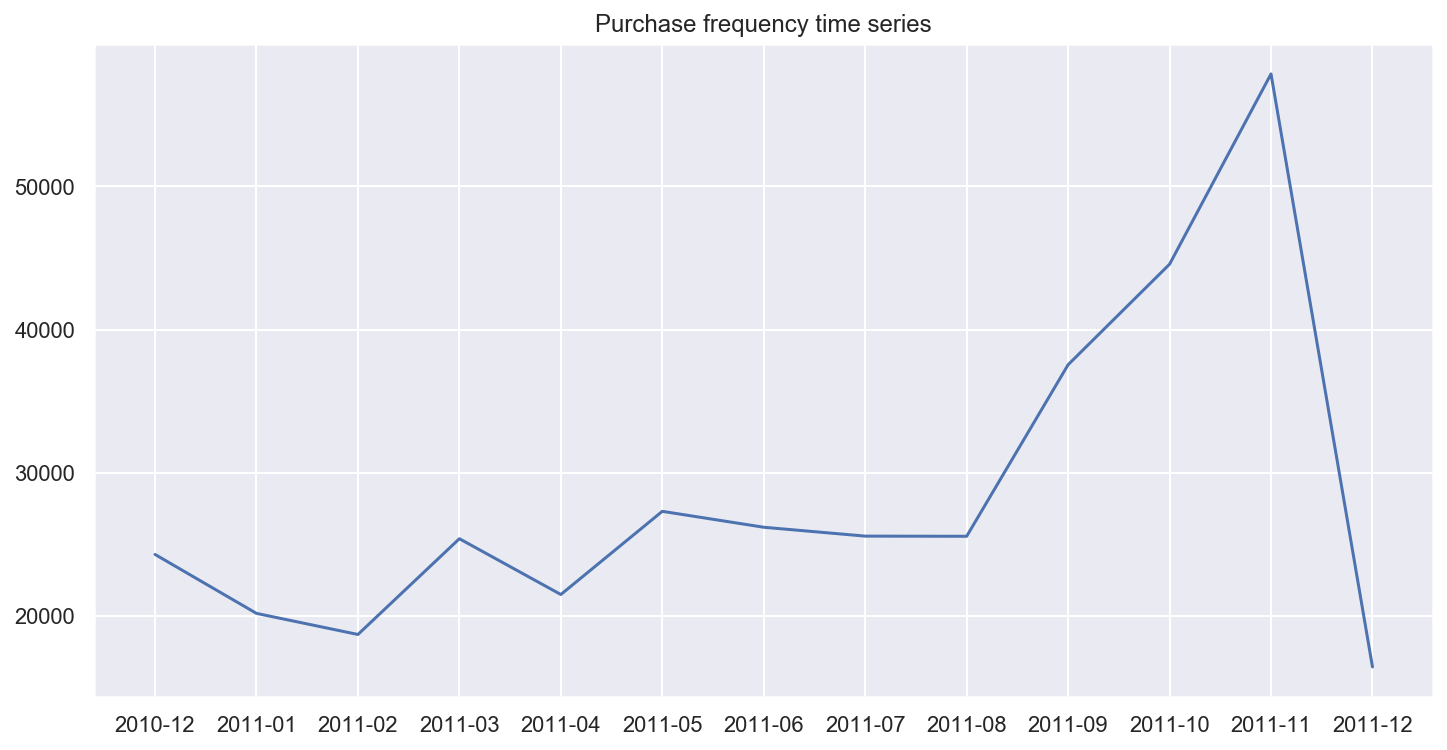

In [27]:
# Visualize number of purchases per month
purchases_per_month = repeat_customers_df['Month_Year'].value_counts().sort_index()

# Set plot
fig = plt.figure(figsize=(12,6))
plt.plot(purchases_per_month.index, purchases_per_month.values, linestyle="-")
plt.title('Purchase frequency time series')
plt.show()

### Reduce sparsity

In [29]:
# Reduce sparcity by excluding users and items without significant event history
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [34]:
# get limited dataset
df_limited = threshold_ratings(repeat_customers_df, 5, 5)

Raw dataset info 
-----------------
Number of users: 3035
Number of items: 3650
Sparsity: 3.351%
Limited dataset info 
-----------------
Number of iterations until convergence: 2
Number of users: 2985
Number of items: 3147
Sparsity: 3.939%


### Train-test split

In [46]:
# Split the data in a way where the train events occour before the test events, in a ratio of 80/20
df_limited['Month_Year'].value_counts(normalize=True).sort_index() * 100

2010-12     6.510980
2011-01     5.427394
2011-02     5.035475
2011-03     6.835597
2011-04     5.785796
2011-05     7.360497
2011-06     7.063450
2011-07     6.896142
2011-08     6.894790
2011-09    10.127441
2011-10    12.025407
2011-11    15.601595
2011-12     4.435435
Name: Month_Year, dtype: float64

In [78]:
# As the last two months (2011-11 and 2011-12) account for 20.03% of all the records 
# the orders made in these months will be used for the test set

# create a train - test data flag
df_limited['train_split'] = (df_limited['Month_Year'] < '2011-11').astype(int)

# check train/test ratio
df_limited['train_split'].value_counts(normalize=True)

1    0.79963
0    0.20037
Name: train_split, dtype: float64

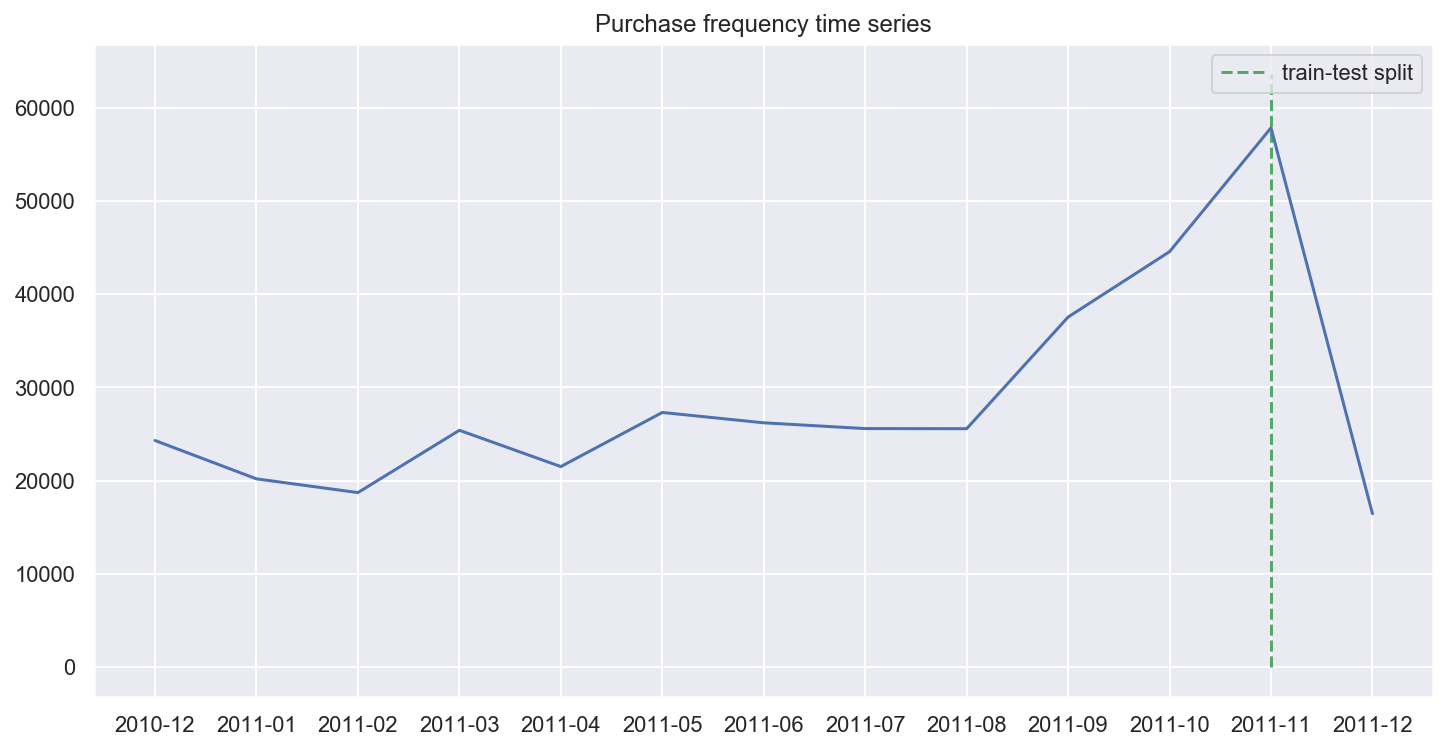

In [66]:
# Visualize the train and test dataset
purchases_per_month = repeat_customers_df['Month_Year'].value_counts().sort_index()

# Set plot
fig = plt.figure(figsize=(12,6))
plt.plot(purchases_per_month.index, purchases_per_month.values, linestyle="-")
plt.vlines(x = '2011-11', ymin= 0, ymax=purchases_per_month.max()*1.1, linestyles='dashed', color='g', label='train-test split')
plt.legend()
plt.title('Purchase frequency time series')
plt.show()

### Train and test raiting matrices

In [86]:
# create series with the customers ids and stock codes as categories
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['StockCode'].astype("category")

# create train sparse matrix 
item_user_train = coo_matrix((df_limited['train_split'], (item_cat.cat.codes,user_cat.cat.codes))).tocsr()

# remove zero entries
item_user_train.eliminate_zeros() 

# produce transpose of item_user_train
user_item_train = item_user_train.T

# create test sparse matrix 
item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                                                                                   (item_cat.cat.codes,
                                                                                    user_cat.cat.codes))).tocsr()
# remove zero entries
item_user_test.eliminate_zeros() 

# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

# Function to get dictionary keys with specifiec value
def get_keys(value, dictionary):
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (3147, 2985) and test set shape: (3147, 2985)
train set percentage of zeros: 97.87852513281373 and test set percentage of zeros: 99.34960258340745


In [87]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [89]:
# get most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['StockCode'] == item_id) & (df_limited['train_split'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year,train_split
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE,2010-12,1
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE,2010-12,1
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE,2010-12,1
37644,539473,C2,CARRIAGE,1,2010-12-19 14:24:00,50.0,14911.0,EIRE,2010-12,1
42332,539984,C2,CARRIAGE,1,2010-12-23 14:58:00,50.0,14911.0,EIRE,2010-12,1
...,...,...,...,...,...,...,...,...,...,...
401116,571425,C2,CARRIAGE,1,2011-10-17 12:41:00,50.0,14911.0,EIRE,2011-10,1
409731,572069,C2,CARRIAGE,1,2011-10-20 13:24:00,50.0,14911.0,EIRE,2011-10,1
414464,572459,C2,CARRIAGE,1,2011-10-24 12:53:00,50.0,14911.0,EIRE,2011-10,1
427576,573391,C2,CARRIAGE,1,2011-10-30 14:57:00,50.0,14911.0,EIRE,2011-10,1


### Fit ALS (Alternating Least Squares) model

In [109]:
alpha = 40
train_conf = (item_user_train * alpha).astype('double')
als_model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=30)

als_model.fit(train_conf)

In [110]:
# Evaluation - Create a model that will predict the most populat product for each user 
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [111]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [112]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.091754,0.057280
map,0.041450,0.024040
ndcg,0.093436,0.058074
auc,0.514523,0.508340
